In [1]:
import cmath, random, numpy
import functools
import  matplotlib.pyplot as plt
import sys
import os
import math
from qutip import*

from sympy import*
#from sympsi import*
from scipy import optimize

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time
import math
from qutip import *
from qutip.ipynbtools import plot_animation
import numpy as np
import matplotlib.pyplot as plt
import qutip
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import display, Math, Latex
import cmath
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.special import factorial as fac


In [2]:
##Some plotting params
xvec = np.arange(-40.,40.)*5./40
yvec = np.arange(-50.,50)*5/40
X,Y = np.meshgrid(xvec, xvec) 
X1,Y1 = np.meshgrid(yvec,yvec)
N_dim = 25##Dimenstion of the Hilbert spac

a1 = destroy(N_dim) ##This is for single-photon field
a2 = destroy(N_dim) ##for coherent field
a3 = destroy(N_dim) ##for vacuum field
def n_choose_k(n,k):
    return fac(n)/(fac(n-k)*fac(k))
def D(state,alpha):
    Rho_new=displace(N_dim,alpha)*state*displace(N_dim,alpha).dag()
    return Rho_new   
'''Define a rotation in phase space, or phase shifter operation'''
def Phase(theta):
    b=-1j*theta*a1.dag()*a1;
    return b.expm()
'''Squeezing operation, inputs a density matrix and outputs the squeezed density matrix for squeezing parameter r'''
def Sq(state,r):
    Rho_new=squeeze(N_dim,r)*state*squeeze(N_dim,r).dag();
    return Rho_new
'''The function below creates a beamsplitter operation that acts on two modes.  
The value for k determines what number Fock state could be filtered out of the first state
based on a single photon input for the second BS port, followed by single photon detection.'''
def BS_operator_filtering(a1, a2, k):
    theta_k = np.arctan(1/np.sqrt(k))
    T = np.sin(theta_k)*np.sin(theta_k)
    R = np.cos(theta_k)*np.cos(theta_k)
    print('I am filtering', k, 'and:', theta_k*180/math.pi)
    print('BS T is : ', T, 'and : ', R)
    b = theta_k*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))
    return b.expm()
def sq_tri_cat(r,amp):
    state=ket2dm((displace(N_dim,amp)*squeeze(N_dim,r)*fock(N_dim,0)+displace(N_dim,amp*np.e**(2j*np.pi/3))*squeeze(N_dim,r*np.e**(4j*np.pi/3))*fock(N_dim,0)+displace(N_dim,amp*np.e**(4j*np.pi/3))*squeeze(N_dim,r*np.e**(2j*np.pi/3))*fock(N_dim,0)))
    norm_state=state/state.tr()
    return norm_state
def SSV_plus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)+displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def SSV_minus(r,alpha):
    state = ket2dm((displace(N_dim,alpha)-displace(N_dim,-alpha))*squeeze(N_dim,r)*fock(N_dim,0))
    norm_state = state/state.tr()
    return norm_state
def cat_plus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1+np.e**(-alpha*alpha.conj()))))*(coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def cat_minus(alpha):
    cat = (1/(np.sqrt(2)*np.sqrt(1-np.e**(-alpha*alpha.conj()))))*(-coherent(N_dim,-alpha)+(coherent(N_dim,alpha)))
    return cat
def pnr_resolution_detector(eta, click, n_truc):
    pi_n = 0;
    l = np.arange(click,n_truc)
    for i in l:
        pi_n +=  n_choose_k(i,click)*math.pow((1-eta),(i-click))*math.pow(eta,click)*fock(N_dim,i)*fock(N_dim,i).dag()
        #print("The final Povm element is: ", pi_0)
    return Qobj(pi_n)
def Fock_Filter_povm(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
        
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def Fock_Filter_prob(in_state,in_fock,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in_state,ket2dm(fock(N_dim,in_fock)));
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    #Rho_filtered=Rho*Projector
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered
def catalysis(in1,in2,refl,num_det,eta,n_truc):
    Projector = tensor(pnr_resolution_detector(eta, num_det, n_truc),qeye(N_dim));
    Initial_state=tensor(in1,in2);
    theta_k=np.arccos(np.sqrt(refl));
    
    BS1= ((theta_k)*(tensor(a1,a2.dag()) - tensor(a1.dag(),a2))).expm()
        
    Rho=BS1*Initial_state*BS1.dag();
    
    P=(Rho*Projector).tr()
    print('The probability of a sucessful detection is:',P)   
    
    Rho_filtered = ((Rho*Projector).ptrace(1))/((Rho*Projector).tr())
    '''The operation .ptrace(m) takes the partial trace over every mode EXCEPT m, where the numbering 
    startes at 0.  So .ptrace(1) means you keep mode 1, which is actually the 2nd mode'''
    print('BS has reflectivity',refl,' and I am detecting the |',num,'> state, where my detector has efficiency', eta)
    return Rho_filtered

def fid(state1,state2):
    F=np.absolute((state1.sqrtm()*state2*state1.sqrtm()).sqrtm().tr())
    return F


In [4]:
def sqrGKP(mu, d, delta, cutoff, nmax=400):  
    r"""Hexagonal GKP code state.
    The Hex GKP state is defined by
    .. math::
        |mu> = \sum_{n_1,n_2=-\infty}^\infty e^{-i(p)
            \sqrt{2\pi/d}(dn_1+\mu)} e^{iq\sqrt{2\pi/d}n_2}|0>
    where d is the dimension of a code space, \mu=0,1,...,d-1, |0> is the
    vacuum state, and the states are modulated by a Gaussian envelope in the
    case of finite energy:
    ..math:: e^{-\Delta ^2 n}|\mu>
    Args:
        d (int): the dimension of the code space.
        mu (int): mu=0,1,...,d-1.
        delta (float): width of the modulating Gaussian envelope.
        cutoff (int): the Fock basis truncation of the returned state vector.
        nmax (int): the Hex GKP state |mu> is calculated by performing the
            sum using n1,n1=-nmax,...,nmax.
    Returns:
        array: a size [cutoff] complex array state vector.
    """
    n1 = np.arange(-nmax, nmax+1)[:, None]
    n2 = np.arange(-nmax, nmax+1)[None, :]

    n1sq = n1**2
    n2sq = n2**2

    sqrt3 = np.sqrt(3)

    #arg1 = -1j*np.pi*n2*(d*n1+mu)/d
    arg1 = 1j*np.pi*n2*(d*n1+mu)/d

    amplitude = (np.exp(arg1)).flatten()[:, None]


    alpha = np.sqrt(np.pi/(d)) * ((d*n1+mu - 1j*n2))

    alpha = alpha.flatten()[:, None]
    n = np.arange(cutoff)[None, :]
    coherent = np.exp(-0.5*np.abs(alpha)**2)*alpha**n/np.sqrt(fac(n))
    
    #hex_state = np.sum(amplitude*coherent*np.exp(-n*delta**2), axis=0)
    sqr_state = ket2dm(Qobj(np.sum(amplitude*coherent*np.exp(-n*delta**2), axis=0)))
    final=sqr_state/sqr_state.tr()
    return final

Text(0.5,0.92,'My gkp state')

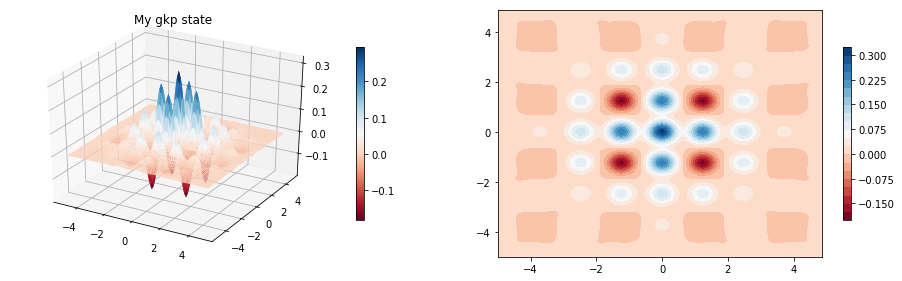

In [5]:
###Test of Square Lattice GKP code

code_d=1

sqr_gkp=sqrGKP(2,code_d,0.4,35);
W_sqr=wigner(sqr_gkp,xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_sqr, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_sqr, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('My gkp state')

The probability of a sucessful detection is: 0.0020343205135781787
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001EF33570048> > state, where my detector has efficiency 1


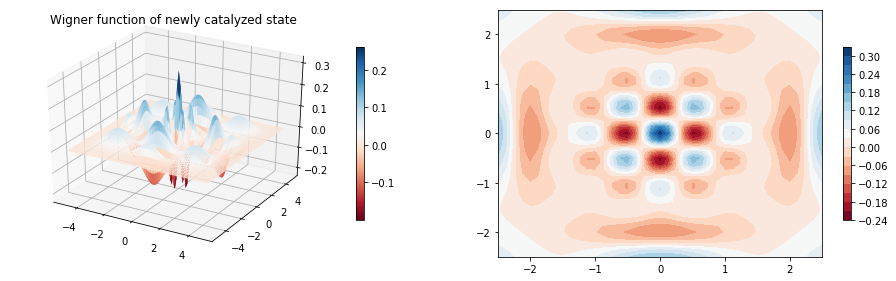

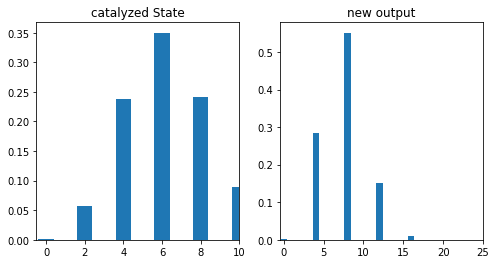

In [10]:
'''Send two cat states (M=2 SSV states) to a balanced beamsplitter, where one state
is pi/2 out of phase with the other, and measure 0 photons on one output.
Does it resemble a GKP state?'''
eta=1;

sq=0.1
amp=2.5
state=SSV_plus(sq,amp)
output=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,0,eta,N_dim)

W_out=wigner(output,xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out, 20, cmap=cm.RdBu)
ax.set_xlim([-2.5,2.5])
ax.set_ylim([-2.5,2.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')


plt.show()

fig, axes = plt.subplots(1, 2, figsize=(8,4))
bar0 = axes[0].bar(range(N_dim), state.diag())

lbl0 = axes[0].set_title("catalyzed State")

lim0 = axes[0].set_xlim([-.5, 10])
bar1 = axes[1].bar(range(N_dim), output.diag())

lbl1 = axes[1].set_title("new output")

lim1 = axes[1].set_xlim([-.5, 25])

The probability of a sucessful detection is: 0.24967255557181023
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001EF33570048> > state, where my detector has efficiency 1


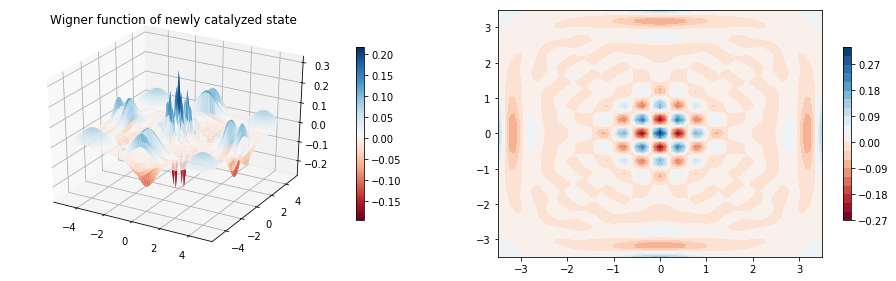

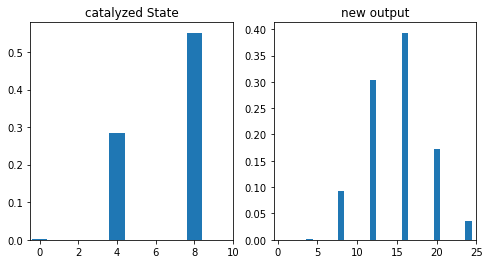

In [12]:
'''Now try with two of the previous outputs, How does the grid state change?'''
rnd2=catalysis(output,output,1/2,0,eta,N_dim)
W_rnd2=wigner(rnd2,xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_rnd2, 20, cmap=cm.RdBu)
ax.set_xlim([-3.5,3.5])
ax.set_ylim([-3.5,3.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_rnd2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')


fig, axes = plt.subplots(1, 2, figsize=(8,4))
bar0 = axes[0].bar(range(N_dim), output.diag())

lbl0 = axes[0].set_title("catalyzed State")

lim0 = axes[0].set_xlim([-.5, 10])
bar1 = axes[1].bar(range(N_dim), rnd2.diag())

lbl1 = axes[1].set_title("new output")

lim1 = axes[1].set_xlim([-.5, 25])

The probability of a sucessful detection is: 0.09243422919090553
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000020FAE0CE048> > state, where my detector has efficiency 1


Text(0.5,0.92,'Wigner function of GKP state')

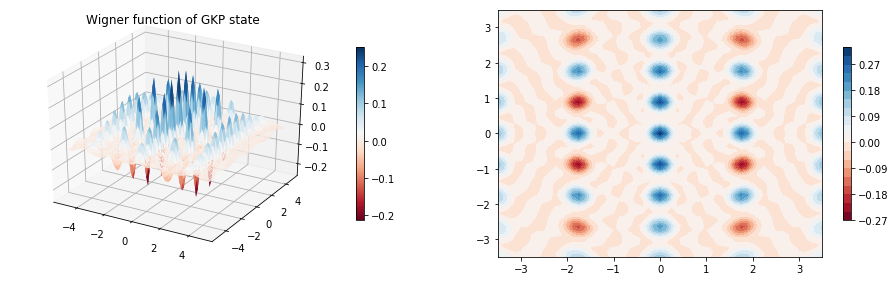

In [11]:
#Define gkp state for comparison
eta=1;
code_d=2

sqr_gkp=sqrGKP(0,code_d,0.2,35);
W_sqr=wigner(sqr_gkp,xvec,xvec)

#Define SSV state (obtained by optimizing Eq 22 in the text for an N=4 photon catalysis procedure)
sq=0.52
amp=1.59
state=SSV_plus(sq,amp)
output=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,4,eta,N_dim)

W_out=wigner(Phase(np.pi/4)*output*Phase(np.pi/4).dag(),xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_sqr, 20, cmap=cm.RdBu)
ax.set_xlim([-3.5,3.5])
ax.set_ylim([-3.5,3.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_sqr, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of GKP state')



In [12]:
'''Now, combine two of the cat states (M=2 SSV states) from above and
perform homodyne detection on one output'''
in1=state.full()
in2=(Phase(np.pi/2)*state*Phase(np.pi/2).dag()).full()
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf
eng, q = sf.Engine(2)
with eng:
    Ket(in1) | q[0]
    Ket(in2) | q[1]
    BSgate()  | (q[0], q[1])
    MeasureHomodyne(np.pi/2,select=0) | q[0]
    #wigner | (q[1].val)
state_final = eng.run('tf', cutoff_dim =25, modes=1, eval=True)
qutip_state=Qobj(state_final.dm())
W_homodyne=wigner(qutip_state,xvec,xvec)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


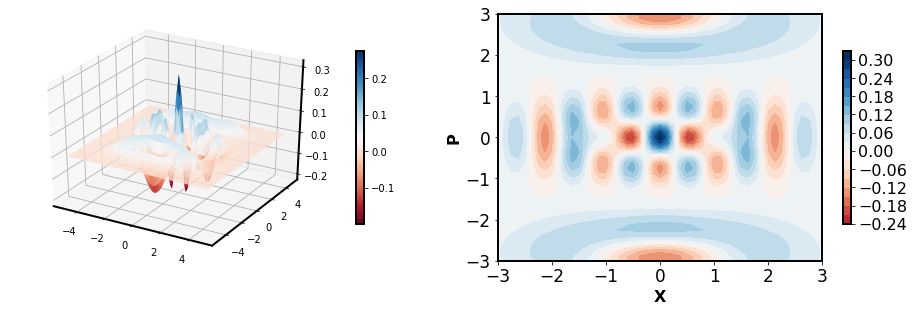

In [17]:
#Plotting results
from pylab import *
rc('axes', linewidth=2)
fontsize=14
plotted=Phase(-np.pi/4)*qutip_state*Phase(-np.pi/4).dag()
W_plot=wigner(plotted,xvec,xvec)
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_homodyne, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_homodyne, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)

In [10]:
'''Perform homodyne detection when there is no phase difference'''
in1=(Phase(np.pi/2)*state*Phase(np.pi/2).dag()).full()
in2=(Phase(np.pi/2)*state*Phase(np.pi/2).dag()).full()
import strawberryfields as sf
from strawberryfields.ops import *
import tensorflow as tf
eng, q = sf.Engine(2)
with eng:
    Ket(in1) | q[0]
    Ket(in2) | q[1]
    BSgate()  | (q[0], q[1])
    MeasureHomodyne(np.pi/2,select=0) | q[0]
    #wigner | (q[1].val)
state_final2 = eng.run('tf', cutoff_dim =25, modes=1, eval=True)
qutip_state2=Qobj(state_final2.dm())
W_homodyne2=wigner(qutip_state2,xvec,xvec)

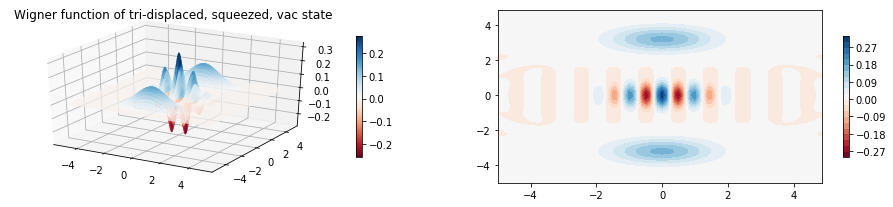

In [11]:
#plot results
fig = plt.figure(figsize=(16,7))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_homodyne2, 20, cmap=cm.RdBu)
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_homodyne2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of tri-displaced, squeezed, vac state')
plt.show()

The probability of a sucessful detection is: 0.09243422919090553
BS has reflectivity 0.5  and I am detecting the | <function num at 0x000001EF33570048> > state, where my detector has efficiency 1
The fidelity between the states is:  0.9961816748056219


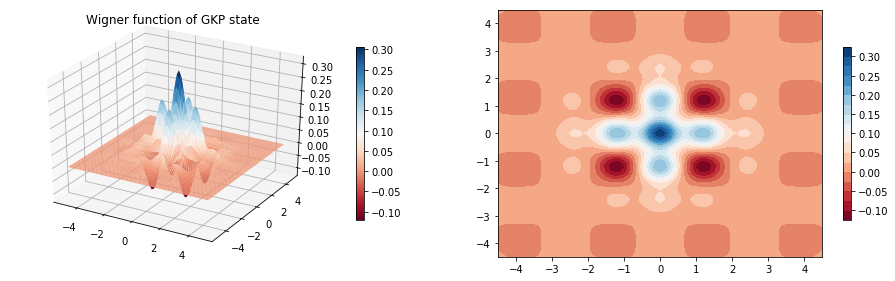

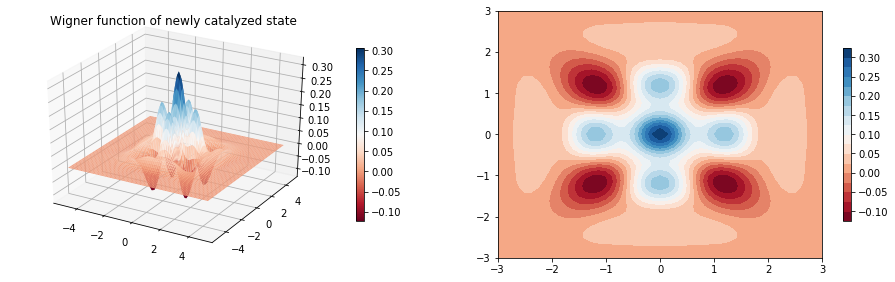

In [13]:
'''Now, compare the state obtained by combining two approximate SSV states (cat states) at a
balanced beamsplitter and perfroming a PNR detection of n=4 photons at one output with an ideal,
finite energy square-lattice GKP state.'''
eta=1;
code_d=1

sqr_gkp=sqrGKP(1,code_d,0.545,25);#peak-width delta=0.545
W_sqr=wigner(sqr_gkp,xvec,xvec)

#sq and amp obtained by optimizing fidelity from eq. 22 in the paper
sq=0.52
amp=1.59
state=SSV_plus(sq,amp)
output=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,4,eta,N_dim)

W_out=wigner(Phase(np.pi/4)*output*Phase(np.pi/4).dag(),xvec,xvec)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_sqr, 20, cmap=cm.RdBu)
ax.set_xlim([-4.5,4.5])
ax.set_ylim([-4.5,4.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_sqr, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of GKP state')

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out, 20, cmap=cm.RdBu)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
plt.title('Wigner function of newly catalyzed state')
fid=fidelity(Phase(np.pi/4)*output*Phase(np.pi/4).dag(),sqr_gkp)
print('The fidelity between the states is: ', fid)

In [14]:
fidelity(Phase(np.pi/4)*output*Phase(np.pi/4).dag(),sqr_gkp)

0.9961816748056219

In [66]:
###PNR detection after mixing two SSV states IN PHASE with each other at a balanced beamsplitter...
###Larger cats? and maybe grid-like GKP states?

eta=1;
code_d=1

sqr_gkp=sqrGKP(2,code_d,0.5,25);
W_sqr=wigner(sqr_gkp,xvec,xvec)

sq=0.52
amp=1.59
state=SSV_plus(sq,amp)
output0=catalysis(state,state,1/2,0,eta,N_dim)
#output1=catalysis(state,state,1/2,1,eta,N_dim)
output2=catalysis(state,state,1/2,2,eta,N_dim)
output3=catalysis(state,state,1/2,3,eta,N_dim)
output4=catalysis(state,state,1/2,4,eta,N_dim)
output5=catalysis(state,state,1/2,5,eta,N_dim)
output6=catalysis(state,state,1/2,6,eta,N_dim)
output7=catalysis(state,state,1/2,7,eta,N_dim)
output8=catalysis(state,state,1/2,8,eta,N_dim)

W_out0=wigner(Phase(np.pi/4)*output0*Phase(np.pi/4).dag(),xvec,xvec)
W_out1=wigner(Phase(np.pi/4)*output1*Phase(np.pi/4).dag(),xvec,xvec)
W_out2=wigner(Phase(np.pi/4)*output2*Phase(np.pi/4).dag(),xvec,xvec)
W_out3=wigner(Phase(np.pi/4)*output3*Phase(np.pi/4).dag(),xvec,xvec)
W_out4=wigner(Phase(np.pi/4)*output4*Phase(np.pi/4).dag(),xvec,xvec)
W_out5=wigner(Phase(np.pi/4)*output5*Phase(np.pi/4).dag(),xvec,xvec)
W_out6=wigner(Phase(np.pi/4)*output6*Phase(np.pi/4).dag(),xvec,xvec)
W_out7=wigner(Phase(np.pi/4)*output7*Phase(np.pi/4).dag(),xvec,xvec)
W_out8=wigner(Phase(np.pi/4)*output8*Phase(np.pi/4).dag(),xvec,xvec)


The probability of a sucessful detection is: 0.43979371941917283
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000017AD22A5E18> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.07792603547444939
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000017AD22A5E18> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 6.859924709104112e-09
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000017AD22A5E18> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.18091739788854108
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000017AD22A5E18> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 8.114815092743314e-09
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000017AD22A5E18> > state, where my detector has efficiency 1
The probability 

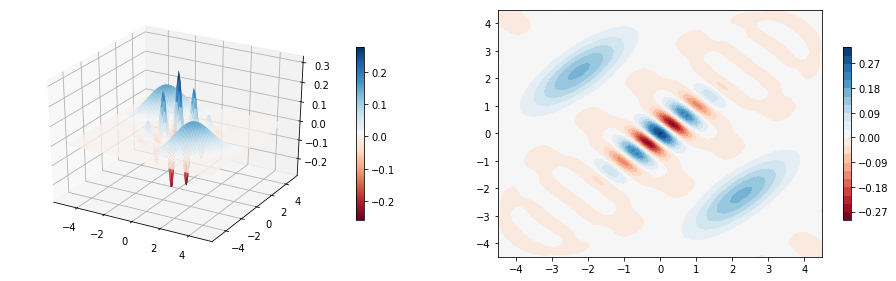

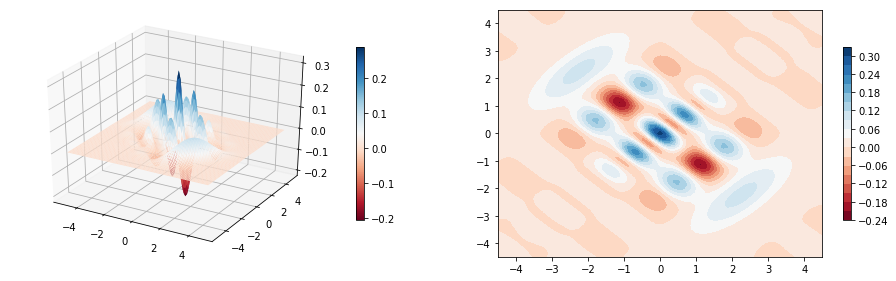

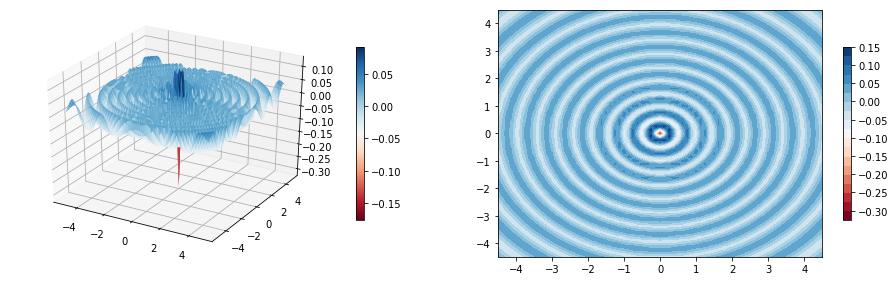

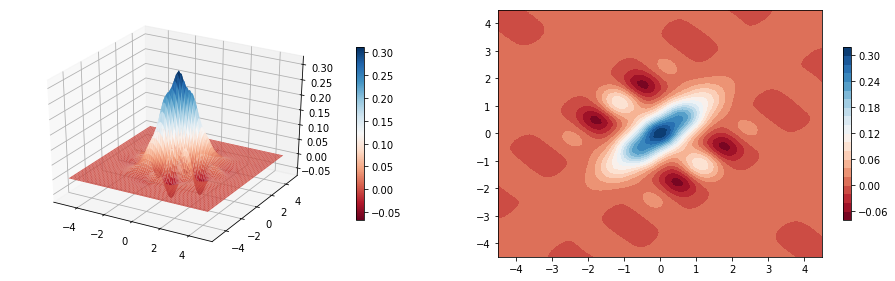

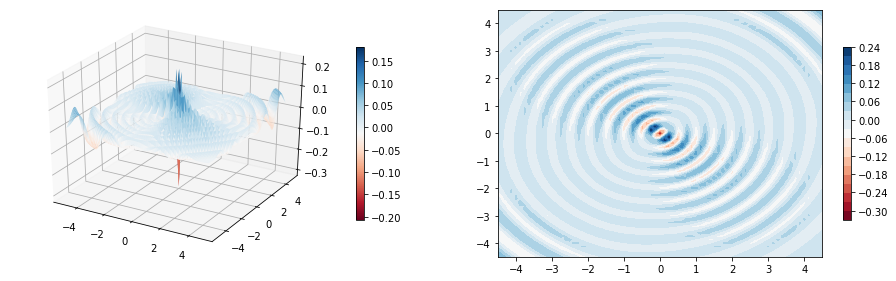

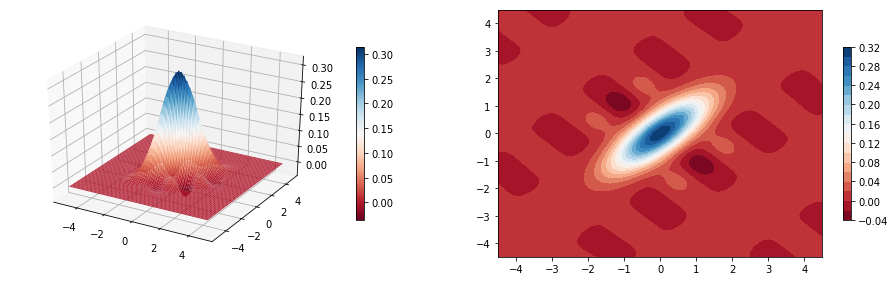

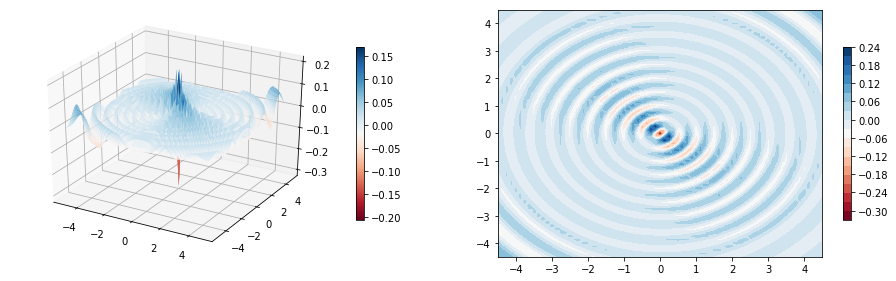

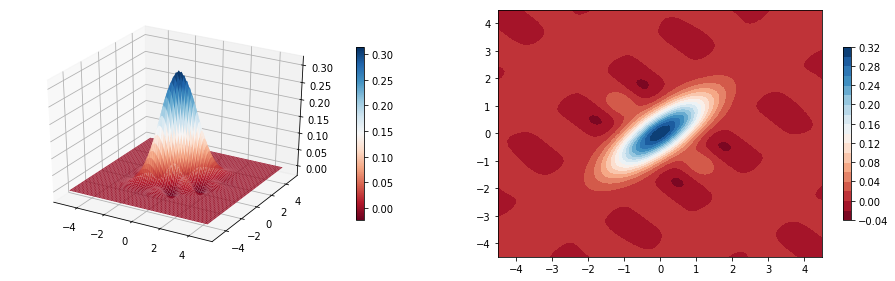

In [71]:
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out0, 20, cmap=cm.RdBu)
ax.set_xlim([-4.5,4.5])
ax.set_ylim([-4.5,4.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out0, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

#fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
#ax = fig.add_subplot(2, 2, 2)
#p = ax.contourf(X, Y, W_out1, 20, cmap=cm.RdBu)
#ax.set_xlim([-4.5,4.5])
#ax.set_ylim([-4.5,4.5])
#cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
#ax = fig.add_subplot(2, 2, 1, projection='3d')
#p = ax.plot_surface(X, Y, W_out1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
#cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out2, 20, cmap=cm.RdBu)
ax.set_xlim([-4.5,4.5])
ax.set_ylim([-4.5,4.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out3, 20, cmap=cm.RdBu)
ax.set_xlim([-4.5,4.5])
ax.set_ylim([-4.5,4.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out3, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out4, 20, cmap=cm.RdBu)
ax.set_xlim([-4.5,4.5])
ax.set_ylim([-4.5,4.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out4, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out5, 20, cmap=cm.RdBu)
ax.set_xlim([-4.5,4.5])
ax.set_ylim([-4.5,4.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out5, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out6, 20, cmap=cm.RdBu)
ax.set_xlim([-4.5,4.5])
ax.set_ylim([-4.5,4.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out6, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out7, 20, cmap=cm.RdBu)
ax.set_xlim([-4.5,4.5])
ax.set_ylim([-4.5,4.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out7, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_out8, 20, cmap=cm.RdBu)
ax.set_xlim([-4.5,4.5])
ax.set_ylim([-4.5,4.5])
cb = fig.colorbar(p, shrink = 0.7)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_out8, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)



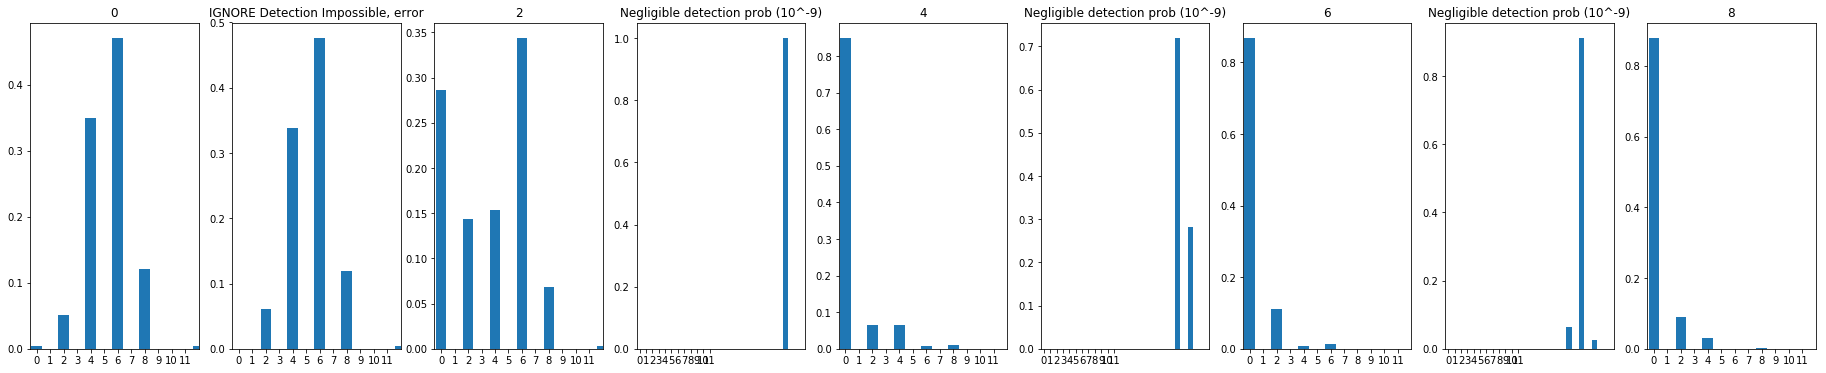

In [88]:
#photon number distribution from the above proceedure
fig, axes = plt.subplots(1, 9, figsize=(32,6))
bar0 = axes[0].bar(range(N_dim), output0.diag())
lbl0 = axes[0].set_title("0")
lim0 = axes[0].set_xlim([-.5, 12])

bar1 = axes[1].bar(range(N_dim), output1.diag())
lbl1 = axes[1].set_title("IGNORE Detection Impossible, error")
lim1 = axes[1].set_xlim([-.5, 12])

bar2 = axes[2].bar(range(N_dim), output2.diag())
lbl2 = axes[2].set_title("2")
lim2 = axes[2].set_xlim([-.5, 12])
bar3 = axes[3].bar(range(N_dim), output3.diag())
lbl3 = axes[3].set_title("Negligible detection prob (10^-9)")
lim3 = axes[3].set_xlim([-.5, 26])

bar4 = axes[4].bar(range(N_dim), output4.diag())
lbl4 = axes[4].set_title("4")
lim4 = axes[4].set_xlim([-.5, 12])

bar5 = axes[5].bar(range(N_dim), output5.diag())
lbl5 = axes[5].set_title("Negligible detection prob (10^-9)")
lim5 = axes[5].set_xlim([-.5, 26])

bar5 = axes[6].bar(range(N_dim), output6.diag())
lbl5 = axes[6].set_title("6")
lim5 = axes[6].set_xlim([-.5, 12])
bar5 = axes[7].bar(range(N_dim), output7.diag())
lbl5 = axes[7].set_title("Negligible detection prob (10^-9)")
lim5 = axes[7].set_xlim([-.5, 26])
bar5 = axes[8].bar(range(N_dim), output8.diag())
lbl5 = axes[8].set_title("8")
lim5 = axes[8].set_xlim([-.5, 12])
axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[2].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[3].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[4].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[5].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[6].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[7].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[8].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])

plt.show()


In [6]:
###PNR detection after mixing two SSV states OUT OF PHASE with each other - gride-like GKP states!
eta=1;
code_d=1

sqr_gkp=sqrGKP(2,code_d,0.5,25);
W_sqr=wigner(sqr_gkp,xvec,xvec)

sq=0.52
amp=1.59
state=SSV_plus(sq,amp)
gkp0=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,0,eta,N_dim)
gkp1=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,1,eta,N_dim)
gkp2=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,2,eta,N_dim)
gkp3=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,3,eta,N_dim)
gkp4=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,4,eta,N_dim)
gkp5=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,5,eta,N_dim)
gkp6=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,6,eta,N_dim)
gkp7=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,7,eta,N_dim)
gkp8=catalysis(state,Phase(np.pi/2)*state*Phase(np.pi/2).dag(),1/2,8,eta,N_dim)

W_0=wigner(Phase(np.pi/4)*gkp0*Phase(np.pi/4).dag(),xvec,xvec)
W_1=wigner(Phase(np.pi/4)*gkp1*Phase(np.pi/4).dag(),xvec,xvec)
W_2=wigner(Phase(np.pi/4)*gkp2*Phase(np.pi/4).dag(),xvec,xvec)
W_3=wigner(Phase(np.pi/4)*gkp3*Phase(np.pi/4).dag(),xvec,xvec)
W_4=wigner(Phase(np.pi/4)*gkp4*Phase(np.pi/4).dag(),xvec,xvec)
W_5=wigner(Phase(np.pi/4)*gkp5*Phase(np.pi/4).dag(),xvec,xvec)
W_6=wigner(Phase(np.pi/4)*gkp6*Phase(np.pi/4).dag(),xvec,xvec)
W_7=wigner(Phase(np.pi/4)*gkp7*Phase(np.pi/4).dag(),xvec,xvec)
W_8=wigner(Phase(np.pi/4)*gkp8*Phase(np.pi/4).dag(),xvec,xvec)


The probability of a sucessful detection is: 0.110313077700168
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000018FD366E048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.18438245084647403
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000018FD366E048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.2196059265154599
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000018FD366E048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.1714898300125672
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000018FD366E048> > state, where my detector has efficiency 1
The probability of a sucessful detection is: 0.09243422919090553
BS has reflectivity 0.5  and I am detecting the | <function num at 0x0000018FD366E048> > state, where my detector has efficiency 1
The probability of a suc

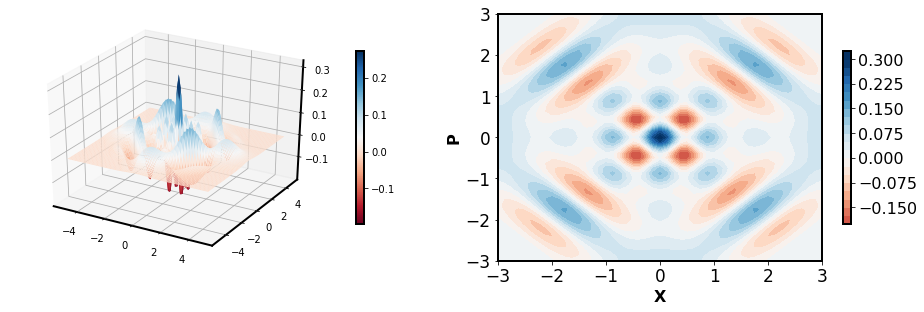

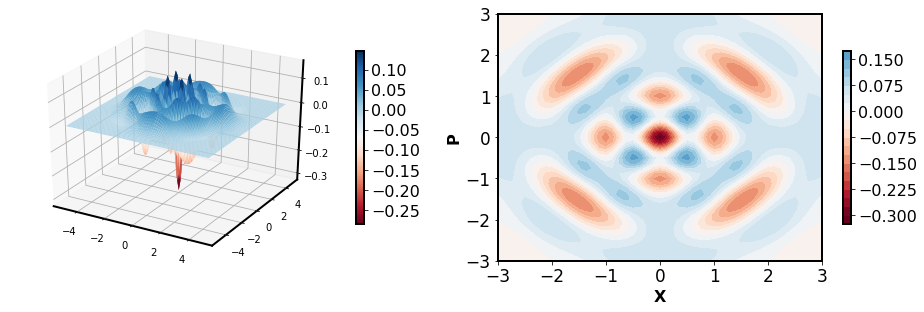

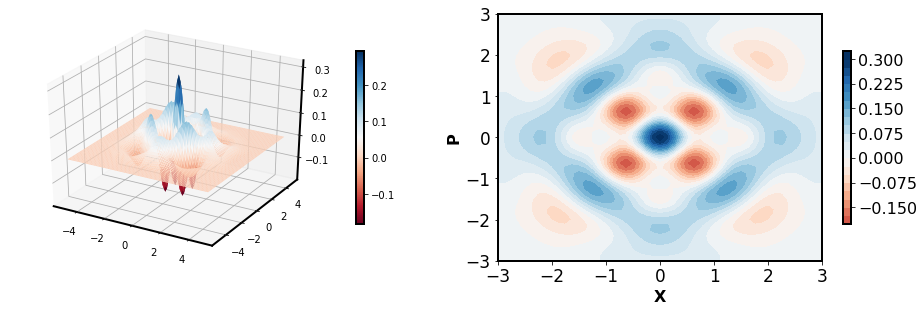

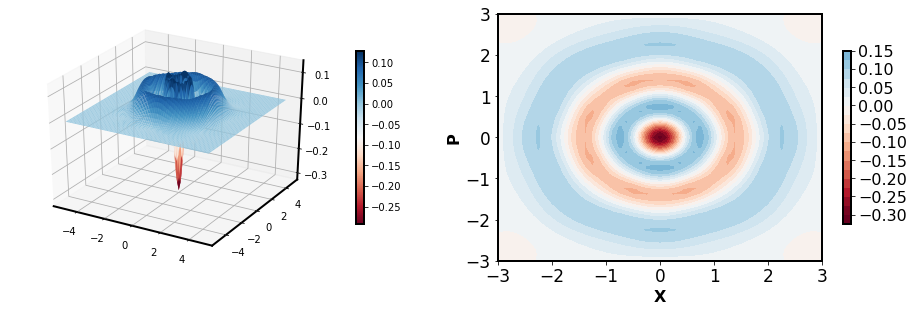

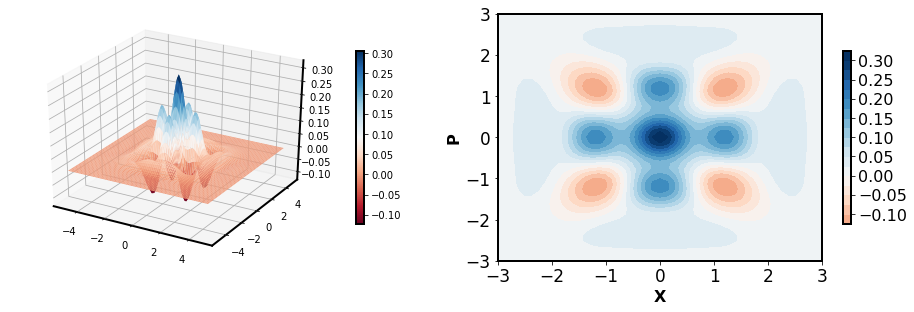

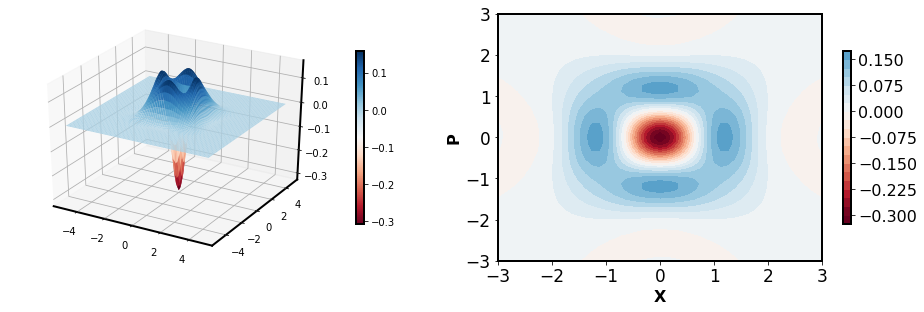

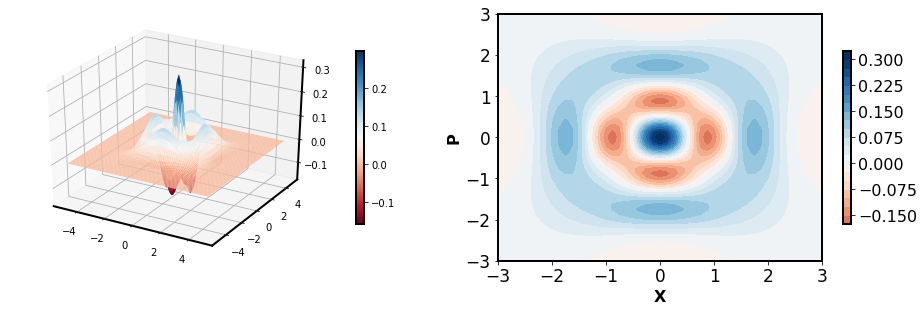

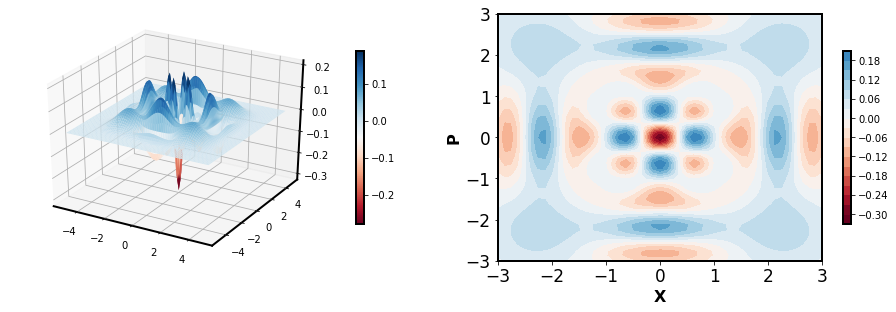

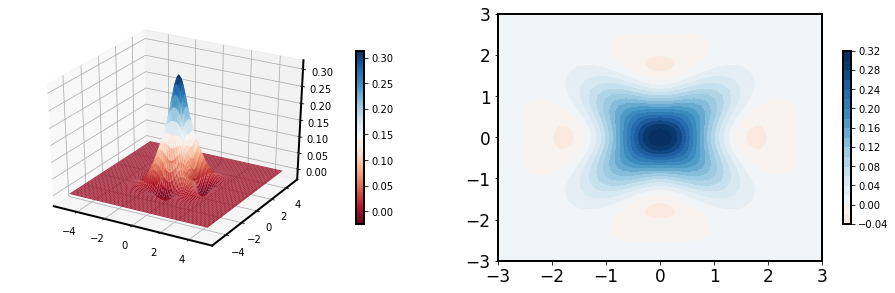

In [7]:
from pylab import *
rc('axes', linewidth=2)
fontsize=14
fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_0, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_0, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)


#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_1, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_1, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
cb.ax.tick_params(labelsize=16)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_2, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_2, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_3, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_3, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_4, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_4, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_5, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_5, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_6, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
cb.ax.tick_params(labelsize=16)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_6, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_7, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.xlabel('X',fontsize=16,fontweight='heavy')
plt.ylabel('P',fontsize=16,fontweight='heavy')
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_7, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)

fig = plt.figure(figsize=(16,10))
# `ax` is a 3D-aware axis instance, because of the projection='3d' keyword argument to add_subplot
ax = fig.add_subplot(2, 2, 2)
p = ax.contourf(X, Y, W_8, 20, cmap=cm.RdBu, vmin=-.3, vmax=.3)
ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
cb = fig.colorbar(p, shrink = 0.7)
plt.tick_params(axis='both', labelsize=17)
# surface_plot with color grading and color bar
ax = fig.add_subplot(2, 2, 1, projection='3d')
p = ax.plot_surface(X, Y, W_8, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0.5)
cb = fig.colorbar(p,shrink = .7)
#plt.title('Wigner function of GKP state')
#print('fidelity with cat:',fid0**2)



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\transforms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


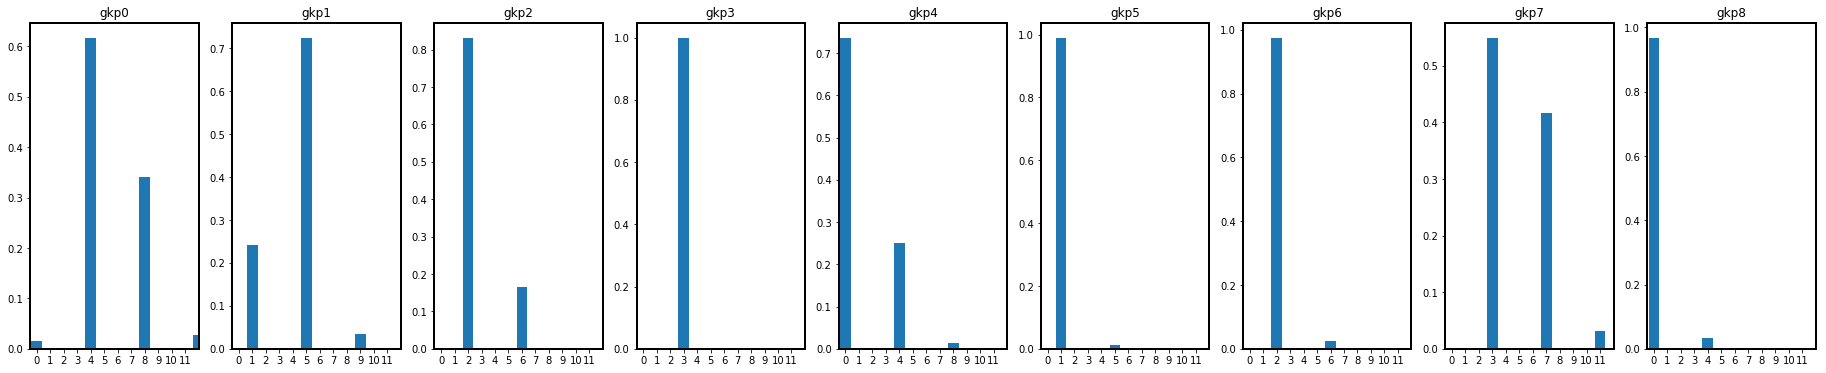

In [8]:
fig, axes = plt.subplots(1, 9, figsize=(32,6))
bar0 = axes[0].bar(range(N_dim), gkp0.diag())
lbl0 = axes[0].set_title("gkp0")
lim0 = axes[0].set_xlim([-.5, 12])

bar1 = axes[1].bar(range(N_dim), gkp1.diag())
lbl1 = axes[1].set_title("gkp1")
lim1 = axes[1].set_xlim([-.5, 12])

bar2 = axes[2].bar(range(N_dim), gkp2.diag())
lbl2 = axes[2].set_title("gkp2")
lim2 = axes[2].set_xlim([-.5, 12])
bar3 = axes[3].bar(range(N_dim), gkp3.diag())
lbl3 = axes[3].set_title("gkp3")
lim3 = axes[3].set_xlim([-.5, 12])

bar4 = axes[4].bar(range(N_dim), gkp4.diag())
lbl4 = axes[4].set_title("gkp4")
lim4 = axes[4].set_xlim([-.5, 12])

bar5 = axes[5].bar(range(N_dim), gkp5.diag())
lbl5 = axes[5].set_title("gkp5")
lim5 = axes[5].set_xlim([-.5, 12])

bar5 = axes[6].bar(range(N_dim), gkp6.diag())
lbl5 = axes[6].set_title("gkp6")
lim5 = axes[6].set_xlim([-.5, 12])
bar5 = axes[7].bar(range(N_dim), gkp7.diag())
lbl5 = axes[7].set_title("gkp7")
lim5 = axes[7].set_xlim([-.5, 12])
bar5 = axes[8].bar(range(N_dim), gkp8.diag())
lbl5 = axes[8].set_title("gkp8")
lim5 = axes[8].set_xlim([-.5, 12])
axes[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[2].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[3].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[4].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[5].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[6].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[7].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
axes[8].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])

plt.show()
